[ 1.  0. -1.  0.]
SDE_coef
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
2.3082489931159094e-16


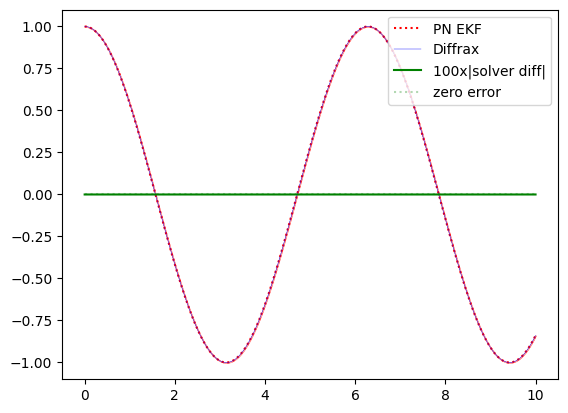

In [28]:
from probabilistic_numerics import kalman_filter as pn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


def vector_field(_t, state, _args):
    x, x_ = state
    return jnp.array([x_, -x])


timesteps = 300

end_time = 10
# Define the ODE term
term = ODETerm(vector_field)
solver = Kvaerno5()
saveat = SaveAt(ts=jnp.linspace(0, end_time, timesteps, endpoint=True))
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Solve the system
diffrax_sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time + 0.1,
    dt0=0.01,
    y0=jnp.array([1.0, 0.0]),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
).ys[:, 0]

real_sol = jnp.cos(jnp.linspace(0, end_time, timesteps))


def pn_solve_nonlinear_IVP(q, ax, n_solution_points, prior_name, prior_matrix):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)
    initial_mean = initial_mean.at[2].set(-1.0)
    initial_mean = initial_mean.at[4].set(1.0)
    print(initial_mean)

    delta = end_time / (n_solution_points - 1)

    def zero_obs(state, time, step):
        return jnp.array([state[0] + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.zeros_like(
            initial_mean
        ),  # jnp.array([0.0, 0.0, 0.0] * state + [1.0] * (state * (q - 2))),
        derivatives=q,
        n_solution_points=n_solution_points,
        delta_time=delta,
        prior_type=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.ones(n_solution_points),
        observation_uncertainty=jnp.eye(1) * 0,
        n_samples=0,
    )
    means = means[:, 0]
    stds = stds[:, 0]
    x_axis = jnp.linspace(0, end_time, timesteps)
    ax.plot(
        x_axis,
        means,
        label="PN EKF",
        linestyle="dotted",
        color="r",
    )
    ax.fill_between(
        x_axis,
        means - stds * 3,
        means + stds * 3,
        alpha=0.4,
        color="r",
    )
    ax.plot(
        x_axis,
        diffrax_sol,
        label="Diffrax",
        color="b",
        linewidth=0.3,
    )
    # ax.plot(
    #     x_axis,
    #     100 * jnp.abs(real_sol - diffrax_sol),
    #     label="100x|real diff|",
    #     color="b",
    # )
    ax.plot(
        x_axis, 100 * jnp.abs(means - real_sol), label="100x|solver diff|", color="g"
    )
    print(jnp.mean((means - real_sol) ** 2))
    ax.plot(
        x_axis,
        timesteps * [0],
        label="zero error",
        color="g",
        linestyle="dotted",
        alpha=0.3,
    )

    ax.legend()
    # ax.set_ylim(-10, 10)
    # ax.axis("off")

    return means, stds


n_points = jnp.logspace(1, 3, 10)

fig, ax = plt.subplots(1, 1)

means, stds = pn_solve_nonlinear_IVP(3, ax, 300, "iwp", -jnp.eye(1))